Autor koda: Šimun Šopar (osim funkcija draw_conv_filters i draw_image, kao i reset_parameters klase ConvolutionModel. Ćelija za pripremu CIFAR podataka također je preuzeta od FER-a, kao što je naznačeno na početku ćelije.)

In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from parse import parse

import math

import skimage as ski

from IPython.display import clear_output

import requests

In [7]:
#methods

class ConvolutionalModel(nn.Module):
    def __init__(self, pic_size, in_channels, conv1_width, pool1_size, stride1, conv2_width, pool2_size, stride2, fc1_width, fc2_width, class_count):
        super().__init__()
        
        self.pic_size = pic_size
        
        self.conv1_width = conv1_width
        
        self.conv1 = nn.Conv2d(in_channels, conv1_width, kernel_size=5, stride=1, padding=2, bias=True)
        self.relu1 = nn.ReLU() 
        self.pool1 = nn.MaxPool2d(kernel_size = pool1_size, stride = stride1)
        
        
        
        for i in range(len(self.pic_size)):        
            self.pic_size[i] = np.floor(1 + (self.pic_size[i] - pool1_size)/stride1)
            
        
        self.conv2 = nn.Conv2d(conv1_width, conv2_width, kernel_size=5, stride=1, padding=2, bias=True)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = pool2_size, stride = stride2)
        
        #self.flat = nn.Flatten()
    
        for i in range(len(self.pic_size)):
            self.pic_size[i] = np.floor(1 + (self.pic_size[i] - pool2_size)/stride2)
    
        # potpuno povezani slojevi
        self.fc1 = nn.Linear((int)(conv2_width * self.pic_size[0] * self.pic_size[1]), fc1_width, bias=True)
        self.fc2 = nn.Linear(fc1_width, fc2_width, bias=True)
        self.fc_logits = nn.Linear(fc2_width, class_count, bias=True)
        

        # parametri su već inicijalizirani pozivima Conv2d i Linear
        # ali možemo ih drugačije inicijalizirati
        self.reset_parameters()
    
    #@author FER
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear) and m is not self.fc_logits:
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
        self.fc_logits.reset_parameters()

    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)
        h = self.pool1(h)
        
        h = self.conv2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        
        
        h = h.reshape(h.shape[0], -1)
        h = self.fc1(h)
        h = torch.relu(h)
        h = self.fc2(h)
        h = torch.relu(h)
        logits = self.fc_logits(h)
        
         
        return logits
    
   
        
    

def loss_fun(y_, logits):
    lsoft = nn.LogSoftmax(dim = 1)
    y = lsoft(logits)
    return -(y_ * y).mean()


def train(model, x, y_, optimizer):
    logits = model.forward(x)
    loss = loss_fun(y_, logits)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    

    
#author FER   
def draw_conv_filters(epoch, step, weights, save_dir):
    w = weights.copy()
    num_filters = w.shape[0]
    num_channels = w.shape[1]
    k = w.shape[2]
    assert w.shape[3] == w.shape[2]
    w = w.transpose(2, 3, 1, 0)
    w -= w.min()
    w /= w.max()
    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    img = np.zeros([height, width, num_channels])
    for i in range(num_filters):
        r = int(i / cols) * (k + border)
        c = int(i % cols) * (k + border)
        img[r:r+k,c:c+k,:] = w[:,:,:,i]
    filename = 'epoch_%02d_step_%06d.png' % (epoch, step)
    ski.io.imsave(os.path.join(save_dir, filename), img)
    
@torch.no_grad()
def evaluate(y_, y, class_count): #uzima ndarray
    confusion_matrices = []
    for c in range(class_count):
        TP = 0; TN = 0; FP = 0; FN = 0
        for i in range(len(y_)):
            if(y_[i] == c):
                if(y[i] == c):
                    TP += 1
                else:
                    FN += 1
            else:
                if(y[i] == c):
                    FP += 1
                else:
                    TN += 1
        confusion_matrices.append([[TP, FP],[FN, TN]])
    return confusion_matrices


#author FER
def draw_image(img, mean, std):
    c_img = img.copy()
    c_img = c_img.transpose(1, 2, 0)
    c_img *= std
    c_img += mean
    c_img = c_img.astype(np.uint8)
    ski.io.imshow(c_img)
    ski.io.show()

In [11]:
#author FER

#data loading

def shuffle_data(data_x, data_y):
    indices = np.arange(data_x.shape[0])
    np.random.shuffle(indices)
    shuffled_data_x = np.ascontiguousarray(data_x[indices])
    shuffled_data_y = np.ascontiguousarray(data_y[indices])
    return shuffled_data_x, shuffled_data_y

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

DATA_DIR = 'CIFAR10 data'

img_height = 32
img_width = 32
num_channels = 3
num_classes = 10

train_x = np.ndarray((0, img_height * img_width * num_channels), dtype=np.float32)
train_y = []
for i in range(1, 6):
    subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
    train_x = np.vstack((train_x, subset['data']))
    train_y += subset['labels']
train_x = train_x.reshape((-1, num_channels, img_height, img_width)).transpose(0, 2, 3, 1)
train_y = np.array(train_y, dtype=np.int32)

subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
test_x = subset['data'].reshape((-1, num_channels, img_height, img_width)).transpose(0, 2, 3, 1).astype(np.float32)
test_y = np.array(subset['labels'], dtype=np.int32)

valid_size = 5000
train_x, train_y = shuffle_data(train_x, train_y)
valid_x = train_x[:valid_size, ...]
valid_y = train_y[:valid_size, ...]
train_x = train_x[valid_size:, ...]
train_y = train_y[valid_size:, ...]
data_mean = train_x.mean((0, 1, 2))
data_std = train_x.std((0, 1, 2))

train_x = (train_x - data_mean) / data_std
valid_x = (valid_x - data_mean) / data_std
test_x = (test_x - data_mean) / data_std

train_x = train_x.transpose(0, 3, 1, 2)
valid_x = valid_x.transpose(0, 3, 1, 2)
test_x = test_x.transpose(0, 3, 1, 2)


dataset_train = TensorDataset(torch.Tensor(train_x), nn.functional.one_hot(torch.Tensor(train_y).to(torch.int64), 10))

train_y_tens = torch.Tensor(train_y).to(torch.int64)
valid_y_tens = torch.Tensor(valid_y).to(torch.int64)

In [5]:
#model and savefile initializer

model = ConvolutionalModel([32, 32], 3, 16, 3, 2, 32, 3, 2, 256, 128, 10)
optimizer = optim.SGD(model.parameters(), lr = 0.01, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

error_log = 'out/zad4/29-3-23_2/error.txt'
error_file = open(error_log, 'w')

lr_log = 'out/zad4/29-3-23_2/lr_log.txt'
lr_file = open(lr_log, 'w')

acc_log = 'out/zad4/29-3-23_2/acc.txt'
acc_file = open(acc_log, 'w')


print('Prije prve epohe:')

print('lr:')
#lr
lr_file.write(str(optimizer.param_groups[0]['lr']) + '\n')


print('Error:')
#log error
logits_train = model.forward(torch.Tensor(train_x))
logits_val = model.forward(torch.Tensor(valid_x))

err_train = loss_fun(nn.functional.one_hot(train_y_tens, 10), logits_train)
err_val = loss_fun(nn.functional.one_hot(valid_y_tens, 10), logits_val)

error_file.write(str(err_train.detach().numpy()) + ' ' + str(err_val.detach().numpy()) + '\n')


print('Acc:')
#acc po klasama
y_pred_train = np.array([np.argmax(y) for y in logits_train.detach().numpy()])
y_pred_val = np.array([np.argmax(y) for y in logits_val.detach().numpy()])

conf1 = evaluate(train_y, y_pred_train, 10)
conf2 = evaluate(valid_y, y_pred_val, 10)

acc_train = 0
acc_val = 0
TP_train = 0
TP_val = 0

for i in range(10):
    acc_train += (conf1[i][0][0] + conf1[i][1][1])/(conf1[i][0][0] + conf1[i][1][1] + conf1[i][0][1] + conf1[i][1][0])
    acc_val += (conf2[i][0][0] + conf2[i][1][1])/(conf2[i][0][0] + conf2[i][1][1] + conf2[i][0][1] + conf2[i][1][0])
    TP_train += conf1[i][0][0]
    TP_val += conf2[i][0][0]

acc_file.write(str(acc_train/10) + ' ' + str(acc_val/10) + ' ' + str(TP_train/len(train_x))  + ' ' + str(TP_val/len(valid_x)) + '\n')
#acc_file.write(str(acc_train/10) + ' ' + str(acc_val/10) + '\n')


print('Crtanje filtara:')
draw_conv_filters(0, 0, model.conv1.weight.detach().numpy(), 'out/zad4/29-3-23_2')

clear_output()

In [6]:
#learning

epoch_num = 20
batch_size = 100

for epoch in range(1, epoch_num + 1):
    
    '''if(epoch == 10):
        requests.post('https://api.mynotifier.app', {
            "apiKey": '44267203-93e7-4cb0-9ae5-6b9dde9d5e8a',
            "message": "Učenje",
            "description": "Na epohi 10 smo",
            "type": "info", # info, error, warning or success
        })'''
    
    loader = DataLoader(dataset_train, batch_size)
    loader = list(loader)
    print('Epoch =', epoch)
    for i, batch in enumerate(loader):
        l = len(loader)
        if(i % 10 == 0):
            print('Progress:', i/l * 100)
        train(model, batch[0], batch[1], optimizer)
    
    scheduler.step()
    clear_output()
    print('Epoch =', epoch)
    print('Crtanje filtara:')
    draw_conv_filters(epoch, 0, model.conv1.weight.detach().numpy(), 'out/zad4/29-3-23_2')
    
    #lr
    print('lr:')
    lr_file.write(str(optimizer.param_groups[0]['lr']) + '\n')
    
    #log error
    print('Error train:')
    logits_train = model.forward(torch.Tensor(train_x))
    print('Error test:')
    logits_val = model.forward(torch.Tensor(valid_x))
    
    err_train = loss_fun(nn.functional.one_hot(train_y_tens, 10), logits_train)
    err_val = loss_fun(nn.functional.one_hot(valid_y_tens, 10), logits_val)
    
    error_file.write(str(err_train.detach().numpy()) + ' ' + str(err_val.detach().numpy()) + '\n')
    
    #acc po klasama
    print('Acc:')
    y_pred_train = np.array([np.argmax(y) for y in logits_train.detach().numpy()])
    y_pred_val = np.array([np.argmax(y) for y in logits_val.detach().numpy()])
    
    conf1 = evaluate(train_y, y_pred_train, 10)
    conf2 = evaluate(valid_y, y_pred_val, 10)
    
    acc_train = 0
    acc_val = 0
    TP_train = 0
    TP_val = 0

    
    for i in range(10):
        acc_train += (conf1[i][0][0] + conf1[i][1][1])/(conf1[i][0][0] + conf1[i][1][1] + conf1[i][0][1] + conf1[i][1][0])
        acc_val += (conf2[i][0][0] + conf2[i][1][1])/(conf2[i][0][0] + conf2[i][1][1] + conf2[i][0][1] + conf2[i][1][0])
        TP_train += conf1[i][0][0]
        TP_val += conf2[i][0][0]
    
    #acc_file.write(str(acc_train/10) + ' ' + str(acc_val/10) + '\n')
    acc_file.write(str(acc_train/10) + ' ' + str(acc_val/10) + ' ' + str(TP_train/len(train_x))  + ' ' + str(TP_val/len(valid_x)) + '\n')
    clear_output()
    
error_file.close()
acc_file.close()
lr_file.close()


requests.post('https://api.mynotifier.app', {
    "apiKey": '44267203-93e7-4cb0-9ae5-6b9dde9d5e8a',
    "message": "Učenje gotovo",
    "description": "Učenje je završeno, model 29-3-23_2",
    "type": "info", # info, error, warning or success
})   #notifier za mobitel kada je učenje gotovo


torch.save(model.state_dict(), 'out/zad4/29-3-23_2/model-29-3-23_2.pth')

In [4]:
error_log = 'out/zad4/29-3-23/error.txt'

lr_log = 'out/zad4/29-3-23/lr_log.txt'

acc_log = 'out/zad4/29-3-23/acc.txt'

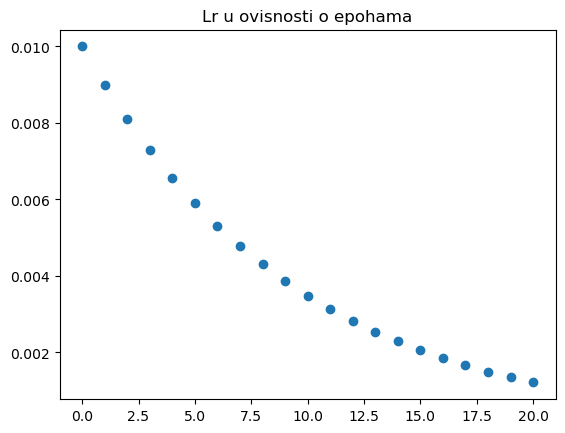

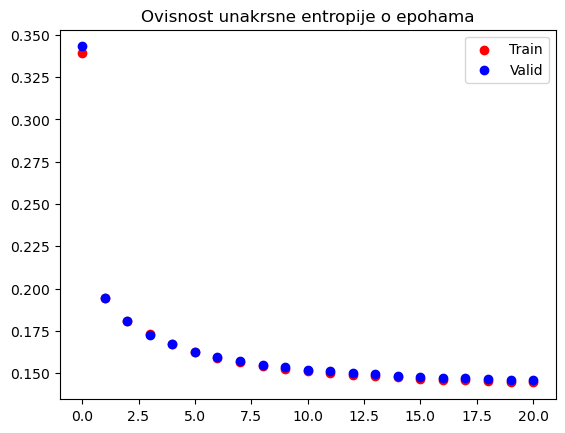

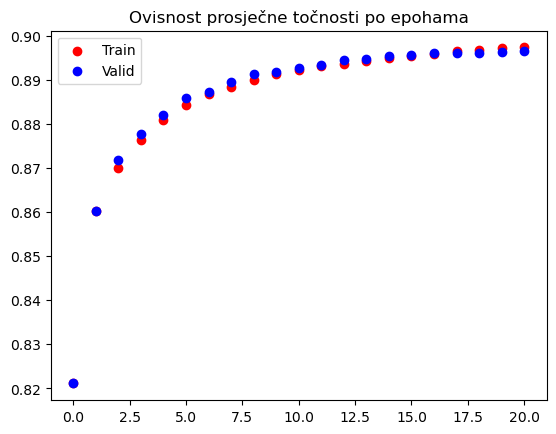

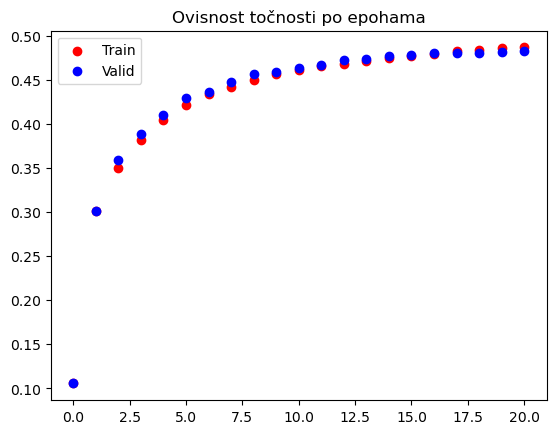

In [5]:
#plotting

lr_file = open(lr_log, 'r')

lr = []

for line in lr_file.readlines():
    lr.append((float)(parse('{}', line)[0]))
    
plt.title('Lr u ovisnosti o epohama')
plt.scatter(np.arange(0, len(lr), 1), lr)
plt.show()

lr_file.close()


#########################


error_file = open(error_log, 'r')

err_train = []
err_val = []

for line in error_file.readlines():
    err1, err2 = parse('{} {}', line)
    err_train.append((float)(err1))
    err_val.append(float(err2))
    
plt.title('Ovisnost unakrsne entropije o epohama')
plt.scatter(np.arange(0, len(err_train)), err_train, label = 'Train', c = 'r')
plt.scatter(np.arange(0, len(err_val)), err_val, label = 'Valid', c = 'b')
plt.legend()
plt.show()
error_file.close()


##########################


acc_file = open(acc_log, 'r')

acc_train = []
acc_val = []

tp_train = []
tp_val = []

for line in acc_file.readlines():
    #acc1, acc2 = parse('{} {}', line)
    acc1, acc2, acc3, acc4 = parse('{} {} {} {}', line)
    acc_train.append(float(acc1))
    acc_val.append(float(acc2))
    tp_train.append(float(acc3))
    tp_val.append(float(acc4))
    
plt.title('Ovisnost prosječne točnosti po epohama')
plt.scatter(np.arange(0, len(acc_train)), acc_train, label='Train', c = 'r')
plt.scatter(np.arange(0, len(acc_val)), acc_val, label='Valid', c = 'b')
plt.legend()
plt.show()

plt.title('Ovisnost točnosti po epohama')
plt.scatter(np.arange(0, len(tp_train)), tp_train, label = 'Train', c = 'r')
plt.scatter(np.arange(0, len(tp_val)), tp_val, label = 'Valid', c = 'b')
plt.legend()
plt.show()

In [9]:
model = ConvolutionalModel([32, 32], 3, 16, 3, 2, 32, 3, 2, 256, 128, 10)
model.load_state_dict(torch.load('out/zad4/29-3-23/model-29-3-23.pth'))

<All keys matched successfully>

In [12]:
#test check

start = 0
stop = 50

y_true = test_y[start:stop]
y_pred = model.forward(torch.Tensor(test_x[start:stop]))

y_pred = np.array([np.argmax(y) for y in y_pred.detach().numpy()])

'''for i in range(len(y_pred)):
    print(y_true[i], y_pred[i])

conf = evaluate(y_true, y_pred, 10)

acc = 0

for i in range(10):
    acc_i = (conf[i][0][0] + conf[i][1][1])/(conf[i][0][0] + conf[i][1][1] + conf[i][0][1] + conf[i][1][0])
    print(acc_i)
    acc += acc_i'''
    
y_true, y_pred

(array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0,
        4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6,
        0, 9, 3, 9, 7, 6]),
 array([6, 1, 8, 0, 4, 6, 1, 6, 3, 1, 8, 9, 6, 1, 1, 2, 5, 3, 8, 4, 7, 0,
        2, 9, 4, 2, 4, 7, 9, 6, 6, 7, 8, 3, 9, 3, 7, 9, 9, 5, 0, 6, 3, 4,
        0, 8, 5, 9, 4, 6], dtype=int64))

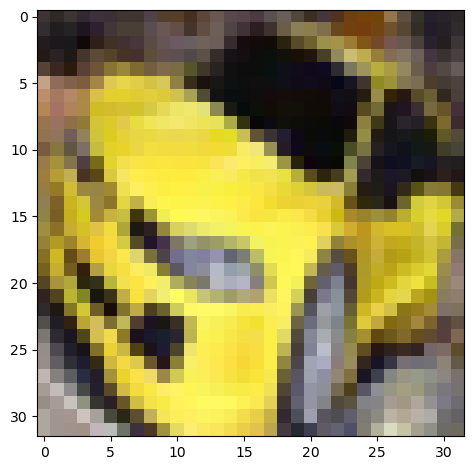

Točan razred je: 1
1. najvjerojatniji razred je 6
2. najvjerojatniji razred je 4
3. najvjerojatniji razred je 2


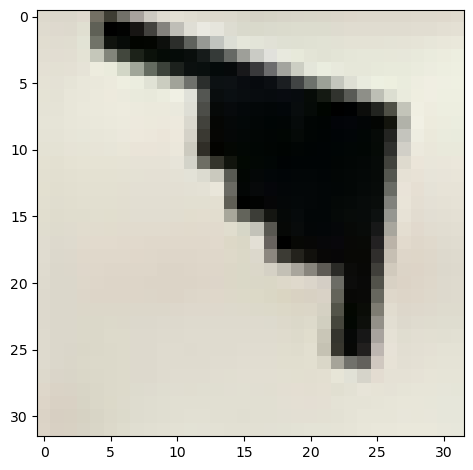

Točan razred je: 0
1. najvjerojatniji razred je 5
2. najvjerojatniji razred je 7
3. najvjerojatniji razred je 3


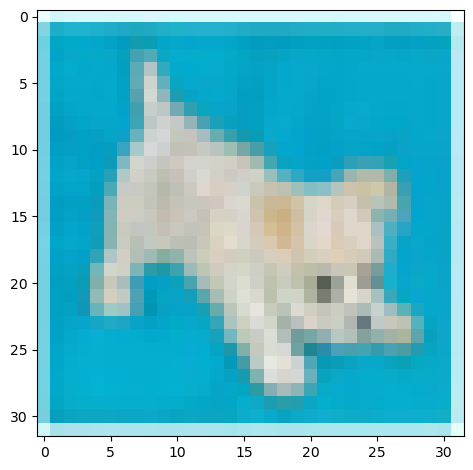

Točan razred je: 5
1. najvjerojatniji razred je 8
2. najvjerojatniji razred je 0
3. najvjerojatniji razred je 2


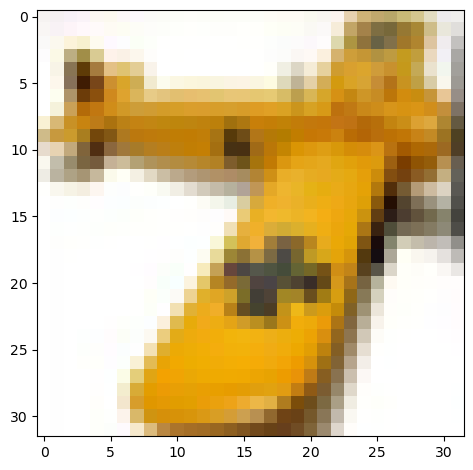

Točan razred je: 0
1. najvjerojatniji razred je 4
2. najvjerojatniji razred je 6
3. najvjerojatniji razred je 2


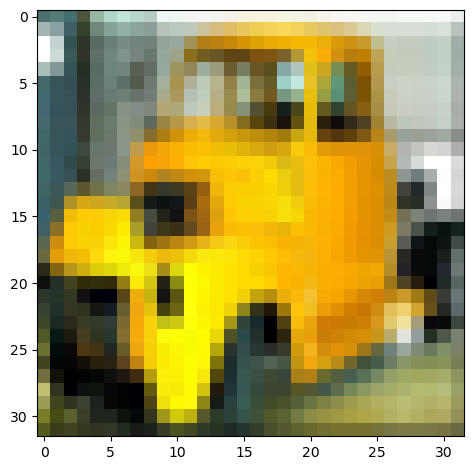

Točan razred je: 9
1. najvjerojatniji razred je 6
2. najvjerojatniji razred je 4
3. najvjerojatniji razred je 2


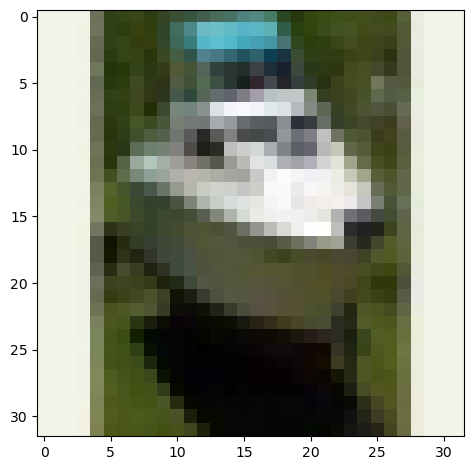

Točan razred je: 8
1. najvjerojatniji razred je 3
2. najvjerojatniji razred je 7
3. najvjerojatniji razred je 6


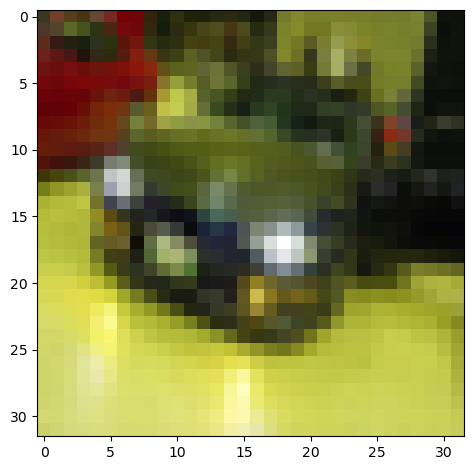

Točan razred je: 1
1. najvjerojatniji razred je 4
2. najvjerojatniji razred je 6
3. najvjerojatniji razred je 7


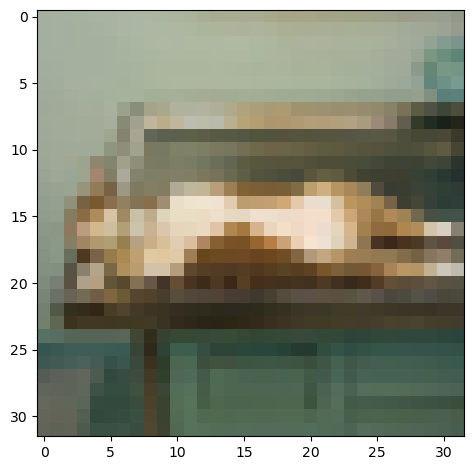

Točan razred je: 3
1. najvjerojatniji razred je 0
2. najvjerojatniji razred je 1
3. najvjerojatniji razred je 9


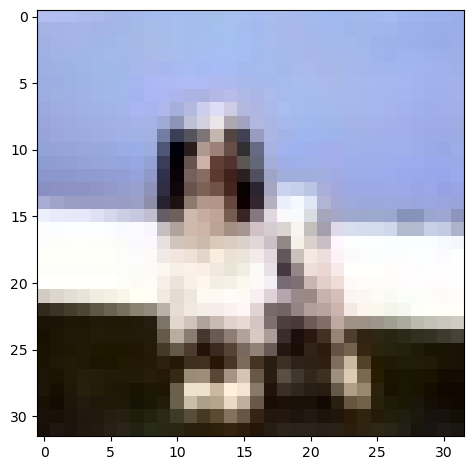

Točan razred je: 5
1. najvjerojatniji razred je 8
2. najvjerojatniji razred je 0
3. najvjerojatniji razred je 9


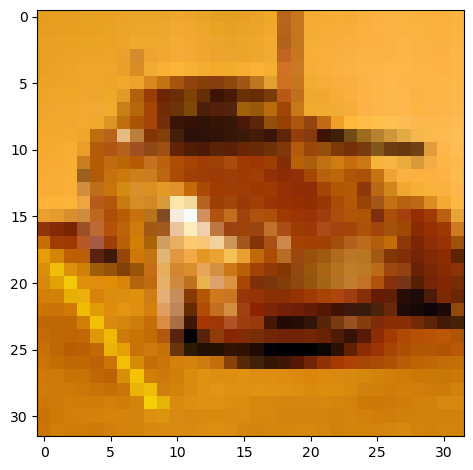

Točan razred je: 1
1. najvjerojatniji razred je 6
2. najvjerojatniji razred je 4
3. najvjerojatniji razred je 2


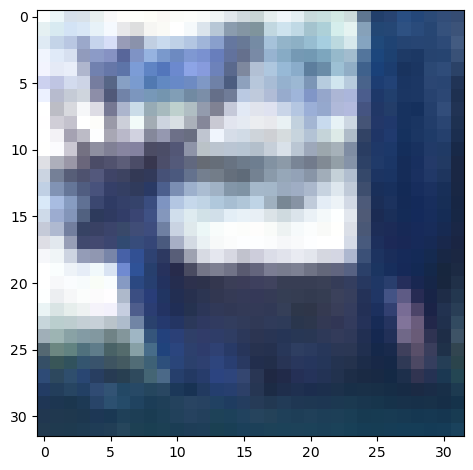

Točan razred je: 4
1. najvjerojatniji razred je 8
2. najvjerojatniji razred je 9
3. najvjerojatniji razred je 1


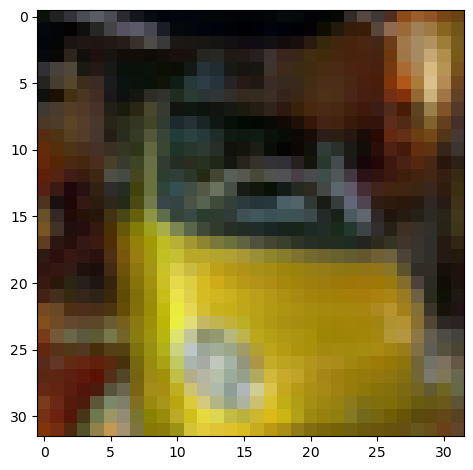

Točan razred je: 1
1. najvjerojatniji razred je 4
2. najvjerojatniji razred je 7
3. najvjerojatniji razred je 3


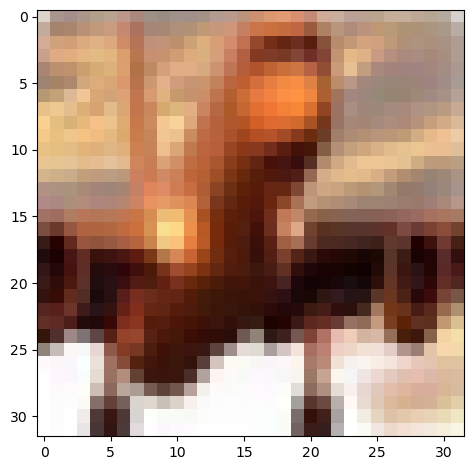

Točan razred je: 0
1. najvjerojatniji razred je 6
2. najvjerojatniji razred je 3
3. najvjerojatniji razred je 9


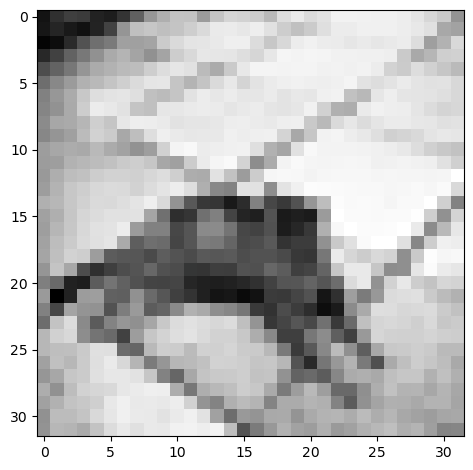

Točan razred je: 3
1. najvjerojatniji razred je 0
2. najvjerojatniji razred je 2
3. najvjerojatniji razred je 4


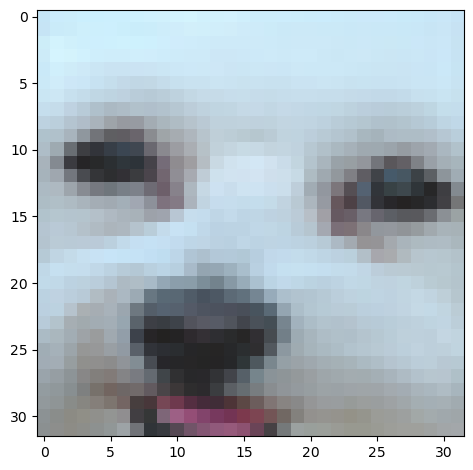

Točan razred je: 5
1. najvjerojatniji razred je 0
2. najvjerojatniji razred je 8
3. najvjerojatniji razred je 9


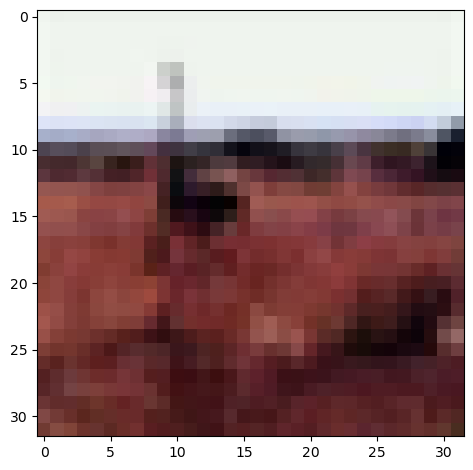

Točan razred je: 2
1. najvjerojatniji razred je 9
2. najvjerojatniji razred je 1
3. najvjerojatniji razred je 8


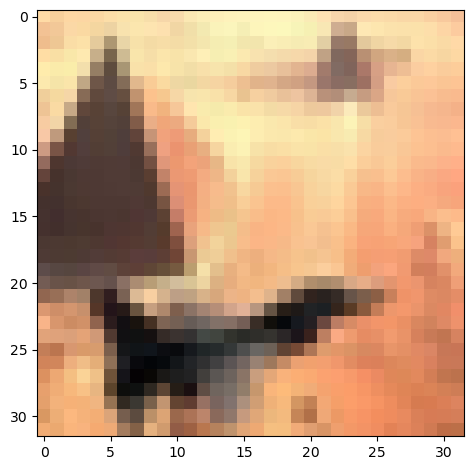

Točan razred je: 0
1. najvjerojatniji razred je 6
2. najvjerojatniji razred je 9
3. najvjerojatniji razred je 3


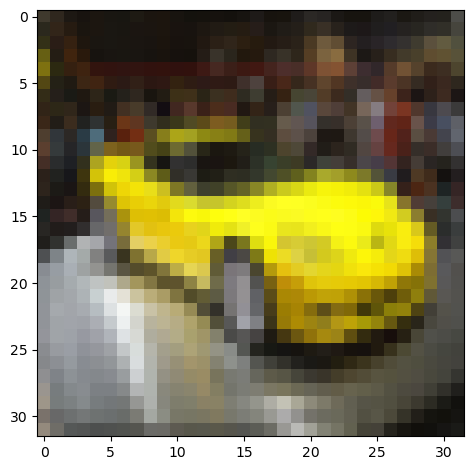

Točan razred je: 1
1. najvjerojatniji razred je 6
2. najvjerojatniji razred je 4
3. najvjerojatniji razred je 2


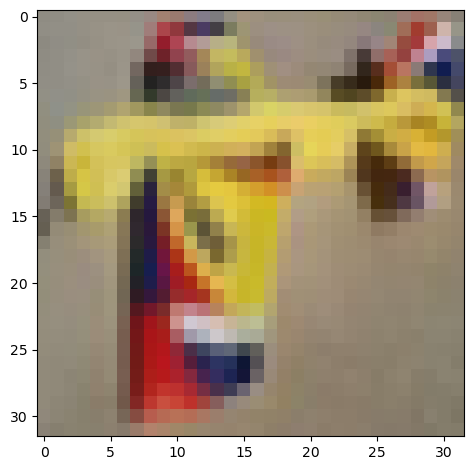

Točan razred je: 0
1. najvjerojatniji razred je 6
2. najvjerojatniji razred je 3
3. najvjerojatniji razred je 2


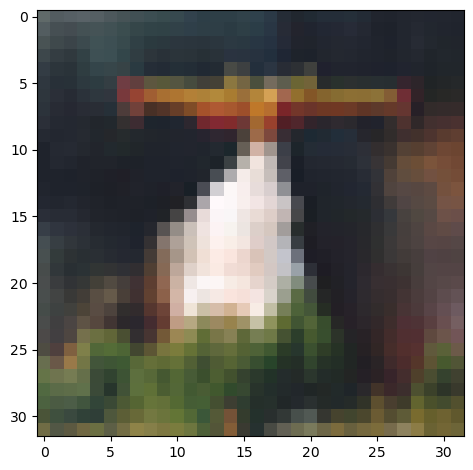

Točan razred je: 0
1. najvjerojatniji razred je 5
2. najvjerojatniji razred je 3
3. najvjerojatniji razred je 2


In [13]:
#plotting worst classifications

loss_mesh = []

y_pred = model.forward(torch.Tensor(test_x))
l = len(test_y)

for i in range(l):
    if(i % 15 == 0):
        print(str(i/l * 100) + '%')
    loss_mesh.append(loss_fun(
        nn.functional.one_hot(torch.Tensor([test_y[i]]).to(torch.int64), 10), y_pred[i].reshape(1, len(y_pred[i]))))

clear_output()

loss_mesh = [float(l.detach().numpy()) for l in loss_mesh]

for i in range(20):
    max_index = np.argmax(loss_mesh)
    loss_mesh[max_index] = 0
    draw_image(test_x[max_index], data_mean, data_std)
    print('Točan razred je:', test_y[max_index])
    for j in range(3):
        max_class = np.argmax(y_pred[max_index].detach().numpy())
        print(str(j + 1) + '. najvjerojatniji razred je ' + str(max_class))
        y_pred[max_index][max_class] = 0

In [9]:
#spremanje modela:

torch.save(model.state_dict(), 'out/zad4/29-3-23/model-29-3-23.pth')

In [15]:
#učitavanje modela:

model2 = ConvolutionalModel([32, 32], 3, 16, 3, 2, 32, 3, 2, 256, 128, 10)
model2.load_state_dict(torch.load('out/zad4/29-3-23/model.pth'))

<All keys matched successfully>

In [13]:
#model and savefile initializer - test area

model_tmp = ConvolutionalModel([32, 32], 3, 16, 3, 2, 32, 3, 2, 256, 128, 10)



3#print('Crtanje filtara:')
draw_conv_filters(-1, 0, model_tmp.conv1.weight.detach().numpy(), 'out/zad4/29-3-23')


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Crtanje filtara:
